# Analysing Calgary Campinas Dataset

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
import imageio
from pathlib import Path
from tqdm import tqdm
from uda import UNetConfig, UNet
from uda.calgary_campinas_dataset import CalgaryCampinasDataset, unpatchify

data_dir = Path("/tmp/data/CC359")
output_dir = Path("/tmp/data/output")
output_dir.mkdir(exist_ok=True, parents=True)

sns.set_theme(style='darkgrid')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"Using device: {device}")

Using device: cuda:0


Load the Calgary Campinas dataset.

In [2]:
train_dataset = CalgaryCampinasDataset(data_dir, vendor="GE_3", fold=1, train=True, patchify=(64, 128, 128), squash_patches=True)
test_dataset = CalgaryCampinasDataset(data_dir, vendor="GE_3", fold=1, train=False, patchify=(64, 128, 128), squash_patches=True)

print(train_dataset.data.shape)
print(train_dataset.label.shape)
print(train_dataset.voxel_dim.shape)

Loading files: 100%|██████████| 20/20 [00:08<00:00,  2.34it/s]


torch.Size([480, 1, 64, 128, 128])
torch.Size([480, 1, 64, 128, 128])
torch.Size([40, 1, 192, 3])


In [3]:
data = test_dataset.data.reshape(-1, np.prod(test_dataset.n_patches), *test_dataset.patchify)
label = test_dataset.label.reshape(-1, np.prod(test_dataset.n_patches), *test_dataset.patchify)
data.shape

torch.Size([20, 12, 64, 128, 128])

Visualize some of the CT images.

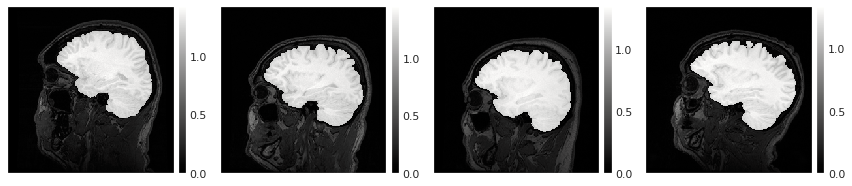

In [4]:
data_v = unpatchify(data, test_dataset.PADDING_SHAPE, start=2)[:4, 63]
label_v = unpatchify(label, test_dataset.PADDING_SHAPE, start=2)[:4, 63]
isns.ImageGrid(list(data_v + label_v), col_wrap=4, cmap="gray");

Visualize the image patches

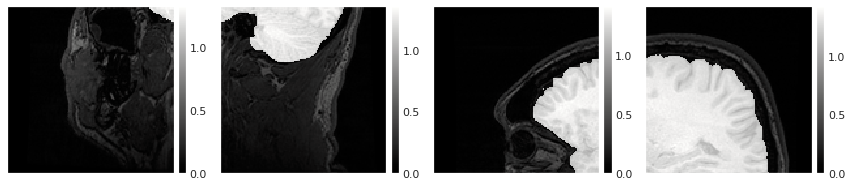

In [5]:
data_v = data[0, :4, 63, ...]
label_v = label[0, :4, 63, ...]

isns.ImageGrid(list(data_v + label_v), col_wrap=4, cmap='gray');

## Training U-Net model

In [ ]:
# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
config = UNetConfig(
    n_classes=1,
    dim=3,
    encoder_blocks=(
        (1, 8, 8),
        (8, 16, 16),
        (16, 32, 32),
        (32, 64, 64),
        (64, 128, 128),
        (128, 256, 256),
    ),
    decoder_blocks=(
        (256, 128, 128),
        (128, 64, 64),
        (64, 32, 32),
        (32, 16, 16),
        (16, 8, 8),
    ),
)

In [ ]:
model = UNet(config)

n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"# parameters: {n_params:,}")

Dice score is a common measure of the quality of segmentation. It's defined as:
$$
DSC = 2 \cdot \frac{\vert Y_{\text{true}} \cap Y_{\text{pred}} \vert}{Y_{\vert\text{true}}\vert + \vert Y_{\text{pred}} \vert}
$$

In [ ]:
def dice_score(pred: torch.Tensor, target: torch.Tensor) -> float:
    pred = pred.reshape(-1)
    target = target.reshape(-1)
    intersection = (pred * target).sum()
    return 2 * intersection / (pred.sum() + target.sum())

Test training pipeline:

In [ ]:
# model = model.to(device)

# x, y_true = next(iter(train_loader))
# x = x.to(device)
# y_true = y_true.to(device)

# print(f"x.shape: {x.shape}")

# y_pred = model(x)

# print(f"y_pred.shape: {y_pred.shape}")
# print(f"y_true.shape: {y_true.shape}")

In [ ]:
# loss = F.binary_cross_entropy(y_pred, y_true)
# print(f"loss: {loss.item():.4f}")

# pred_mask = (y_pred.detach() > 0.5).float()
# dsc = dice_score(pred_mask, y_true)
# print(f"dice score: {dsc:.4f}")

# loss.backward()

Train the model:

In [ ]:
model = UNet(config).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

TEST_INTERVAL = 25
MAX_STEPS = 200

train_losses, test_losses = [], []
train_dscs, test_dscs = [], []

i = 0
dsc_test = 0
with tqdm(total=MAX_STEPS, desc="Training") as pbar:
    while i < MAX_STEPS:
        for x, y_true in train_loader:
            i += 1
            if i > MAX_STEPS:
                break

            x = x.to(device)
            y_true = y_true.to(device)

            optim.zero_grad()
            y_pred = model(x)

            loss = F.binary_cross_entropy(y_pred, y_true)

            loss.backward()
            optim.step()

            pred_mask = (y_pred.detach() > 0.5).float()
            train_losses.append(loss.item())
            train_dscs.append(dice_score(pred_mask, y_true).item())

            if i % TEST_INTERVAL == 0:
                preds, targets = [], []
                with torch.no_grad():
                    preds, targets = [*zip(*[(model(x.to(device)).cpu(), y_true) for x, y_true in test_loader])]
                    preds = torch.cat(preds)
                    targets = torch.cat(targets)

                    pred_mask = (preds > 0.5).float()
                    test_losses.append(F.binary_cross_entropy(preds, targets).item())
                    test_dscs.append(dice_score(pred_mask, targets).item())
                
            pbar.set_postfix({
                "loss": sum(train_losses[-5:]) / 5,
                "dsc_train": sum(train_dscs[-5:]) / 5,
                "dsc_test": test_dscs[-1] if test_dscs != [] else 0
            })
            pbar.update()

model.cpu();

Visualize losses and dice score:

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.lineplot(x=range(len(train_losses)), y=train_losses, label=f"train ({train_losses[-1]:.4f})", ax=ax[0])
sns.lineplot(x=range(TEST_INTERVAL, len(train_losses) + 1, TEST_INTERVAL), y=test_losses, label=f"test ({test_losses[-1]:.4f})", ax=ax[0])

sns.lineplot(x=range(len(train_dscs)), y=train_dscs, label=f"train ({train_dscs[-1]:.4f})", ax=ax[1])
sns.lineplot(x=range(TEST_INTERVAL, len(train_dscs) + 1, TEST_INTERVAL), y=test_dscs, label=f"test ({test_dscs[-1]:.4f})", ax=ax[1])

plt.legend()
plt.show()

Safe the model.

In [ ]:
config.save(output_dir / "unet3d_config.json")
model.save(output_dir / "unet3d_model.pt")

## Analysing model outputs
! Restart notebook to free gpu memory

In [7]:
# load pretrained model
config = UNetConfig.from_file(output_dir / "unet3d_config.json")
model = UNet.from_pretrained(output_dir / "unet3d_model.pt", config)

Gather model outputs:

In [8]:
model = model.to(device)
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

with torch.no_grad():
    data, label, pred = [*zip(*[(data, label, model(data.to(device)).cpu()) for data, label in dataloader])]

data = torch.cat(data)
label = torch.cat(label)
pred = (torch.cat(pred) > 0.5).long()

In [9]:
dsc = dice_score(pred, label).item()
print(f"DSC = {dsc:.4f}")

DSC = 0.9761


In [10]:
data = data.reshape(-1, np.prod(test_dataset.n_patches), *test_dataset.patchify)
label = label.reshape(-1, np.prod(test_dataset.n_patches), *test_dataset.patchify)
pred = pred.reshape(-1, np.prod(test_dataset.n_patches), *test_dataset.patchify)

data = unpatchify(data, test_dataset.PADDING_SHAPE, start=2)
label = unpatchify(label, test_dataset.PADDING_SHAPE, start=2)
pred = unpatchify(pred, test_dataset.PADDING_SHAPE, start=2)

data.shape

torch.Size([20, 192, 256, 256])

Predictions vs. ground truth:

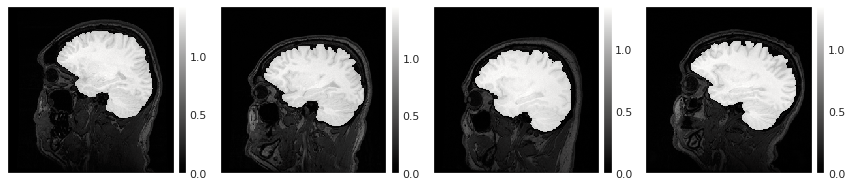

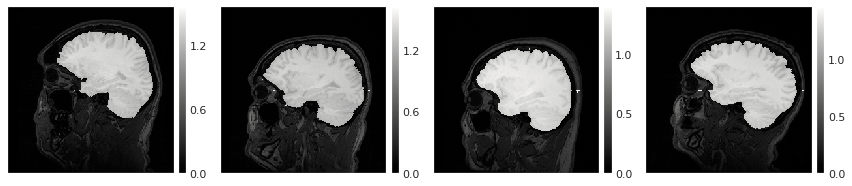

In [11]:
isns.ImageGrid(list((data[:4, 64] + label[:4, 64])), col_wrap=4, cmap='gray')
isns.ImageGrid(list((data[:4, 64] + pred[:4, 64])), col_wrap=4, cmap='gray');

### Safe predictions and ground truth as tif files

In [13]:
def write_tiff(array: np.ndarray, path: Path) -> None:
    array = (array * 255).squeeze().numpy().astype(np.uint8)
    imageio.mimwrite(path, array)

write_tiff(data[0], output_dir / "test_data_0_3d.tiff")
write_tiff(label[0], output_dir / "test_mask_0_3d.tiff")
write_tiff(pred[0], output_dir / "test_pred_0_3d.tiff")